In [1]:
import logging
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pysm3.units as u

from cmbml.utils.handle_data import (
    get_planck_obs_data, 
    get_planck_noise_data, 
    # get_planck_hm_data, 
    get_map_dtype
    )
from cmbml.utils.fits_inspection import get_field_unit

from system_config import ASSETS_DIRECTORY, PLANCK_NOISE_DIRECTORY

In [2]:
# Logging was helpful when debugging my handle_data module
logging.basicConfig(
    level=logging.WARNING,  # If DEBUG, there's a bunch of PySM3 and Matplotlib stuff
    format='%(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

In [20]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            noise_map_unit=None,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + f"({noise_map_unit.to_string('latex_inline')})"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        ells = np.arange(len(ps)).astype(float)
        if x_low < 1:
            ells[0] = x_low
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [4]:
def downgrade_map_via_alm(some_map, target_nside):
    source_nside = hp.get_nside(some_map)
    if source_nside == target_nside:
        return some_map
    assert target_nside <= source_nside/2, "Target nside must be less than the source nside"
    lmax_source = 3 * source_nside - 1
    alm = hp.map2alm(some_map, lmax=lmax_source)

    lmax_target = int(3 * target_nside - 1)
    alm_filter = np.zeros(lmax_source+1)
    alm_filter[:lmax_target+1] = 1
    alm_filtered = hp.almxfl(alm, alm_filter)
    some_map_filtered = hp.alm2map(alm_filtered, nside=target_nside)
    return some_map_filtered

In [5]:
def load_downgrade_and_ps_noise_sims(det, n_sims, nside_out):
    all_noise_maps = []
    all_noise_cls = []
    for i in range(n_sims):
        fn = get_planck_noise_data(detector=det, assets_directory=PLANCK_NOISE_DIRECTORY, realization=i)
        noise_map = hp.read_map(fn)
        noise_map_down = downgrade_map_via_alm(noise_map, nside_out)
        noise_cls = hp.anafast(noise_map_down, lmax=3*nside_out-1)

        all_noise_maps.append(noise_map_down)
        all_noise_cls.append(noise_cls)
    return all_noise_maps, all_noise_cls

In [13]:
det = 100
n_sims = 10
nside_out = 512
min_max = dict(min=-5e-5, max = 5e-5)
unit = u.MJy / u.sr if det in [545, 857] else u.K_CMB

In [7]:
planck_noise_maps_512, planck_noise_cls_512 = load_downgrade_and_ps_noise_sims(det, n_sims, nside_out)

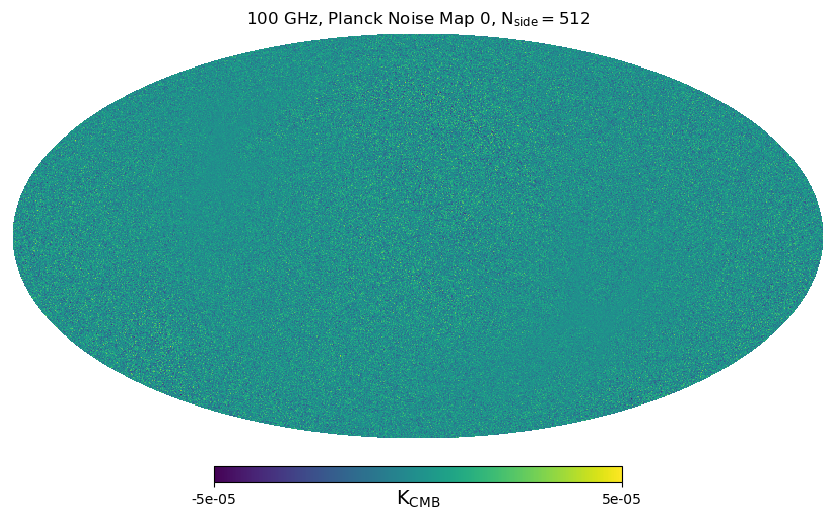

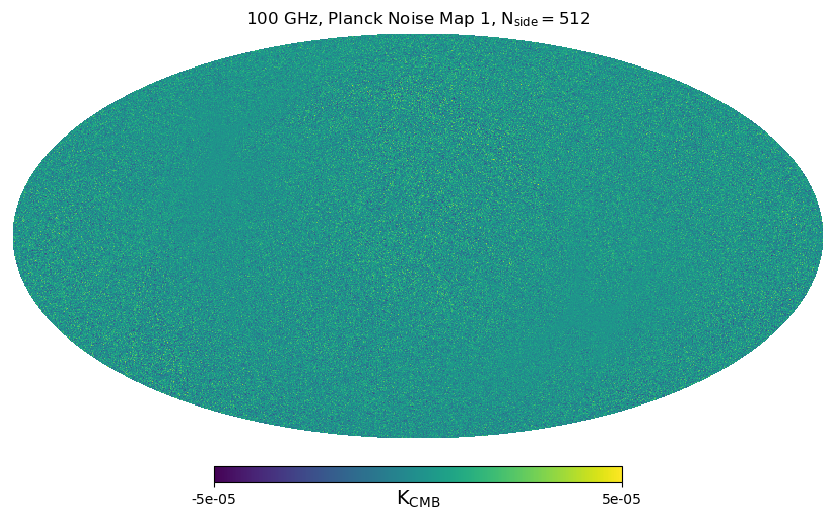

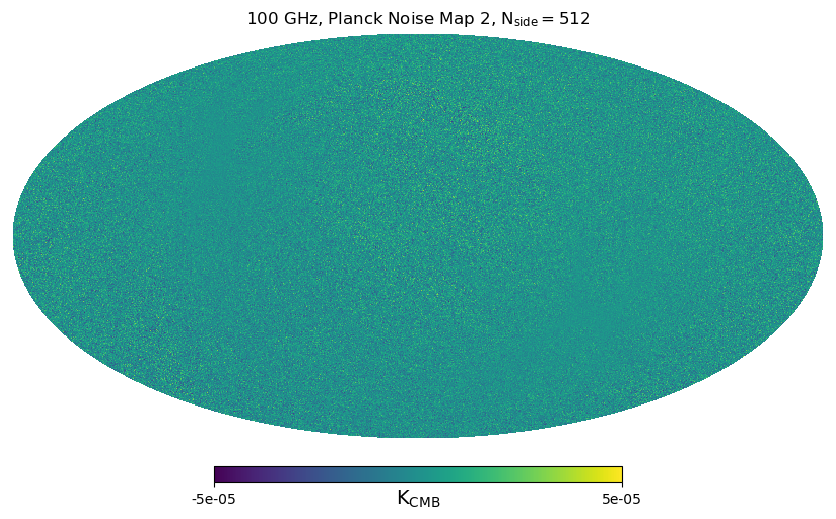

In [16]:
for i in range(n_sims):
    hp.mollview(planck_noise_maps_512[i], 
                title=f"{det} GHz, Planck Noise Map {i}, " + "$\\mathrm{N}_\\mathrm{side} =$" + f"{nside_out}", 
                unit=unit.to_string('latex_inline'),
                **min_max, 
                )
    plt.show()

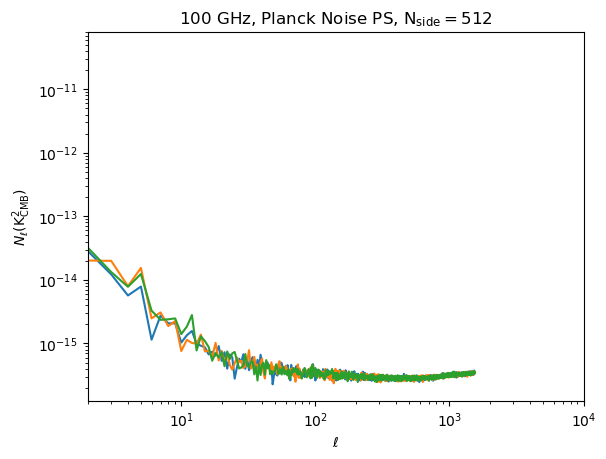

In [21]:
plot_many_ps(planck_noise_cls_512, 
             title=f"{det} GHz, Planck Noise PS, " + "$\\mathrm{N}_\\mathrm{side} =$" + f"{nside_out}", 
             noise_map_unit=unit**2,
             labels=[f"Sim {i}" for i in range(n_sims)],
             x_low=2, x_high=1e4, 
             y_low=None, y_high=None,
             legend=False
             )